This notebook is used to implement the AAMP algorithm of the matrix profile from the following paper:

https://arxiv.org/pdf/1901.05708.pdf

It claims to be faster than the Keogh and Mueen algorithm SCRIMP++. It computes the distances with a non-normalized Euclidean distance.

In [1]:
from IPython.display import Image

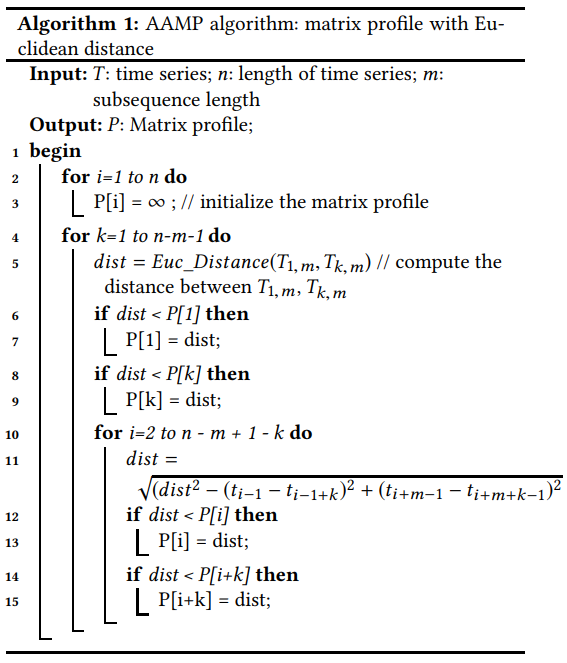

In [2]:
Image('images/matrixprofileAAMP.PNG')

In [3]:
import numpy as np

In [4]:
sampledata = np.loadtxt('sampledata.txt')

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
from matrixprofile.matrixProfile import stomp

In [23]:
%load_ext Cython

In [25]:
%%cython
import numpy as np

cdef aamp(t, m):
    """
    Computes the matrix profile using squared distance to optimize
    computation.
    
    Parameters
    ----------
    t : np.array
        Series object to compute the matrix profile.
    m : int
        Window size.
    
    Returns
    -------
    tuple : (np.array, np.array)
        The matrix profile and matrix profile index.
    """
    t = np.array(t)
    
    # initialize profile
    n = len(t)
    s = n - m
    p = np.full(s, np.inf)
    pi = np.full(s, np.inf)
    
    # Additional optimization - Powers of 2 are better to compute than
    # odd numbers.
    if len(t) % 2 == 1:
        t = np.insert(t, 0, 0)
    
    for k in range(s - 1):
        a = t[0:m]
        b = t[k+1:m+k+1]
        d = np.sum((a - b) ** 2)
        
        if d < p[0]:
            p[0] = d
            pi[0] = k
        
        if d < p[k]:
            p[k] = d
            pi[k] = 0
        
        for i in range(s - k - 1):
            kplusi = k + i + 1
            d = d - (t[i] - t[kplusi]) ** 2 + (t[m+i] - t[m+kplusi]) ** 2
            
            if p[i] > d:
                p[i] = d
                pi[i] = kplusi
            
            if p[kplusi] > d:
                p[kplusi] = d
                pi[kplusi] = i
    
    p = np.sqrt(p)
    return (p, pi)

unable to execute 'gcc': No such file or directory


CompileError: command 'gcc' failed with exit status 1

In [8]:
a = np.array([1, 2, 3])
a ** 2

array([1, 4, 9])

## Experiment 1
In this experiment I compare STOMP with the AAMP algorithm on a synthetic data set.

In [9]:
t = sampledata
m = 32

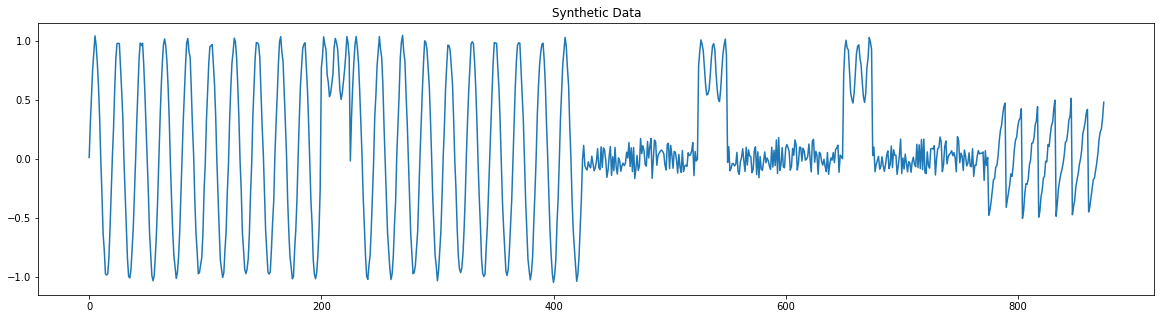

In [10]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(t)), t)
plt.title('Synthetic Data')
plt.show()

In [11]:
%%timeit
p, pi = aamp(t, m)

905 ms ± 123 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
p, pi = aamp(t, m)

In [13]:
%%timeit
stomp_mp, stomp_idx = stomp(np.array(t), m)

248 ms ± 26.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
stomp_mp, stomp_idx = stomp(np.array(t), m)

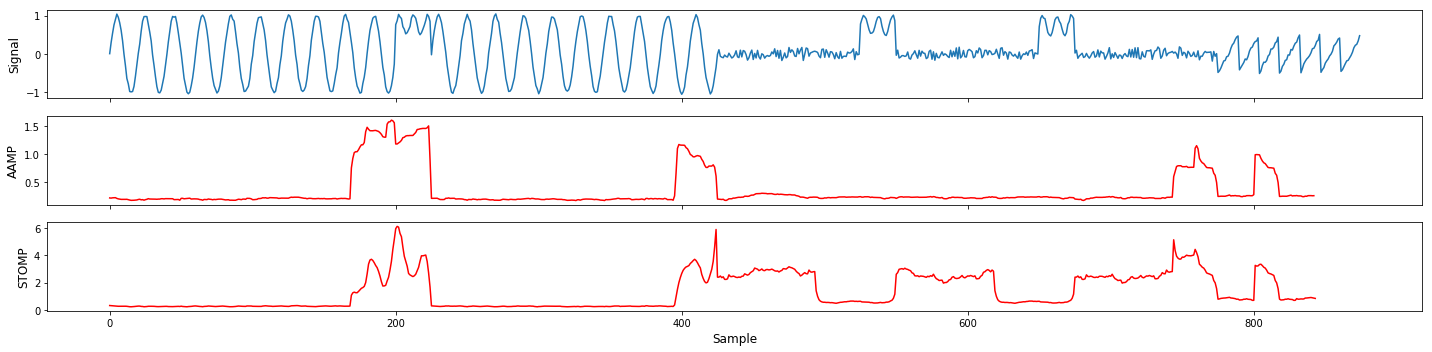

In [15]:
#Plot the signal data
fig, (ax1, ax2, ax3) = plt.subplots(3,1,sharex=True,figsize=(20,5))
ax1.plot(np.arange(len(t)), t, label="Synthetic Data")
ax1.set_ylabel('Signal', size=12)

#Plot the Matrix Profile
mp_adj = p
ax2.plot(np.arange(len(mp_adj)), mp_adj, label="AAMP Matrix Profile", color='red')
ax2.set_ylabel('AAMP', size=12)

#Plot the Matrix Profile
mp_adj = np.append(stomp_mp, np.zeros(m-1)+np.nan)
ax3.plot(np.arange(len(mp_adj)), mp_adj, label="STOMP Matrix Profile", color='red')
ax3.set_ylabel('STOMP', size=12)
ax3.set_xlabel('Sample', size=12)

plt.tight_layout()
plt.show()

In the first expirment, you see that STOMP is significantly faster when compared in Python. The research paper claims that the window size (m) and series length (n) are major factors when comparing the algorithms. Note that in the paper they compare SCRIMP++. However, at this time I do not have a Python implementation of SCRIMP++. Also, STOMP is faster than SCRIMP++ according to Keogh's paper, <a href="https://www.cs.ucr.edu/~eamonn/SCRIMP_ICDM_camera_ready_updated.pdf" target="_blank">Matrix Proﬁle XI: SCRIMP++: Time Series Motif Discovery at Interactive Speed</a>.

The distance profiles of both the AAMP and STOMP algorithm differ. This is due to the differences in calculation. The AAMP algorith does not Z-Normalize the data.

## Experiment 2

In this experiment I generate a uniform distribution and follow what the research claims; m an n are major factors in time complexity.

In [16]:
t = np.random.uniform(size=2**10)
m = 2 ** 5

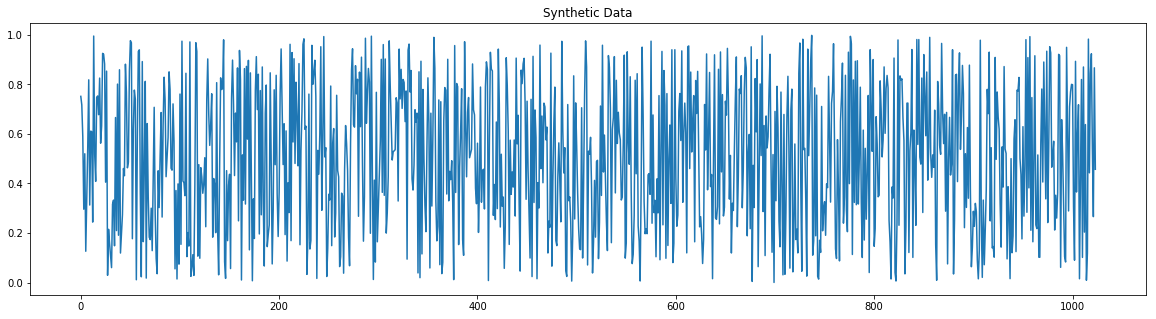

In [17]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(t)), t)
plt.title('Synthetic Data')
plt.show()

In [18]:
%%timeit
p, pi = aamp(t, m)

1.37 s ± 170 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%%timeit
stomp_mp, stomp_idx = stomp(np.array(t), m)

349 ms ± 41.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In this experiment we see that STOMP is still faster.

## Experiment 3 - Matlab runtimes of AAMP vs SCRIMP++

I reached out to the author of the paper to identify any issues with their claims. They provided me with the Matlab code used in their experiments. This experiment compares Matlab implementations to one another.

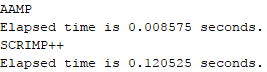

In [20]:
Image('images/matlab_scrimp_aamp.PNG')

The AAMP algorithm performs significantly faster than the SCRIMP++ algorithm within Matlab. I'm not too familiar with Matlab as a whole, but it seems that there is some sort of optimization that lacks within the Python implementation.